<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Factor Risk Exposure

By Evgenia "Jenny" Nitishinskaya, Delaney Granizo-Mackenzie, and Maxwell Margenot.


## DISCLAIMER

As always, this analysis is based on historical data, and risk exposures estimated on historical data may or may not affect the exposures going forward. As such, computing the risk exposure of a factor is not enough. You must put confidence bounds on that risk exposure, and determine whether the risk exposure can even be modeled reasonably. For more information on this, please see our other lectures, especially Instability of Parameter Estimates.


## Using Factor Models to Determine Risk Exposure

We can use factor models to analyze the sources of risks and returns in portfolios. Recall that a factor model expresses the returns as

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$

By modelling the historical returns, we can see how much of them is due to speculation on different factors and how much to asset-specific fluctuations ($\epsilon_p$). We can also examine what sources of risk the portfolio is exposed to. 

In risk analysis, we often model active returns (returns relative to a benchmark) and active risk (standard deviation of active returns, also known as tracking error or tracking risk).

For instance, we can find a factor's marginal contribution to active risk squared (FMCAR). For factor $j$, this is

$$ \text{FMCAR}_j = \frac{b_j^a \sum_{i=1}^K b_i^a Cov(F_j, F_i)}{(\text{Active risk})^2} $$

where $b_i^a$ is the portfolio's active exposure to factor $i$. This tells us how much risk we incur by being exposed to factor $j$, given all the other factors we're already exposed to.

Fundamental factor models are often used to evaluate portfolios because they correspond directly to investment choices (e.g. whether we invest in small-cap or large-cap stocks, etc.). Below, we construct a model to evaluate a single asset; for more information on the model construction, check out the fundamental factor models notebook.

We'll use the canonical Fama-French factors for this example, which are the returns of portfolios constructred based on fundamental factors.

## How many factors do you want?

In the Arbitrage Pricing Theory lecture we mention that for predictive models you want fewer parameters. However, this doesn't quite hold for risk exposure. Instead of trying to not overfit a predictive model, you are looking for any possible risk factor that could be influencing your returns. Therefore it's actually safer to estimate exposure to many many risk factors to see if any stick. Anything left over in our $\alpha$ is risk exposure that is currently unexplained by the selected factors. You want your strategy's return stream to be all alpha, and to be unexplained by as many parameters as possible. If you can show that your historical returns have little to no dependence on many factors, this is very positive. Certainly some unrelated risk factors might have spurious relationships over time in a large dataset, but those are not likely to be consistent.

## Setup

The first thing we do is compute a year's worth of factor returns. 

**NOTE**

The process for doing this is described in the Fundamental Factor Models lecture and uses pipeline. For more information please see that lecture.

In [1]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels import regression
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import numpy as np
from zipline.pipeline import Pipeline
from zipline.pipeline.data import sharadar, EquityPricing
from zipline.pipeline.factors import CustomFactor, Returns
        
def make_pipeline():
    """
    Create and return our pipeline.
    
    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation.
    
    In particular, this function can be copy/pasted into research and run by itself.
    """
    pipe = Pipeline()

    Fundamentals = sharadar.Fundamentals.slice(dimension='ARQ', period_offset=0)
    
    # Add our factors to the pipeline
    market_cap = Fundamentals.MARKETCAP.latest
    
    # Raw market cap and book to price data gets fed in here
    pipe.add(market_cap, "market_cap")
    book_to_price = 1/Fundamentals.PB.latest
    pipe.add(book_to_price, "book_to_price")
    
    # We also get daily returns
    returns = Returns(inputs=[EquityPricing.close], window_length=2)
    pipe.add(returns, "returns")
    
    # We compute a daily rank of both factors, this is used in the next step,
    # which is computing portfolio membership.
    market_cap_rank = market_cap.rank()
    pipe.add(market_cap_rank, 'market_cap_rank')
    
    book_to_price_rank = book_to_price.rank()
    pipe.add(book_to_price_rank, 'book_to_price_rank')

    # Build Filters representing the top and bottom 1000 stocks by our combined ranking system.
    biggest = market_cap_rank.top(1000)
    smallest = market_cap_rank.bottom(1000)
    
    highpb = book_to_price_rank.top(1000)
    lowpb = book_to_price_rank.bottom(1000)
    
    # Don't return anything not in this set, as we don't need it.
    pipe.set_screen(biggest | smallest | highpb | lowpb)
    
    # Add the boolean flags we computed to the output data
    pipe.add(biggest, 'biggest')
    pipe.add(smallest, 'smallest')
    
    pipe.add(highpb, 'highpb')
    pipe.add(lowpb, 'lowpb')
    
    return pipe

pipe = make_pipeline()

In [3]:
from zipline.research import run_pipeline

start_date = '2014-01-01'
end_date = '2015-01-01'

results = run_pipeline(pipe, start_date=start_date, end_date=end_date, bundle='usstock-1d-bundle')

R_biggest = results[results.biggest]['returns'].groupby(level=0).mean()
R_smallest = results[results.smallest]['returns'].groupby(level=0).mean()

R_highpb = results[results.highpb]['returns'].groupby(level=0).mean()
R_lowpb = results[results.lowpb]['returns'].groupby(level=0).mean()

SMB = R_smallest - R_biggest
HML = R_highpb - R_lowpb

How did each factor do over 2014?

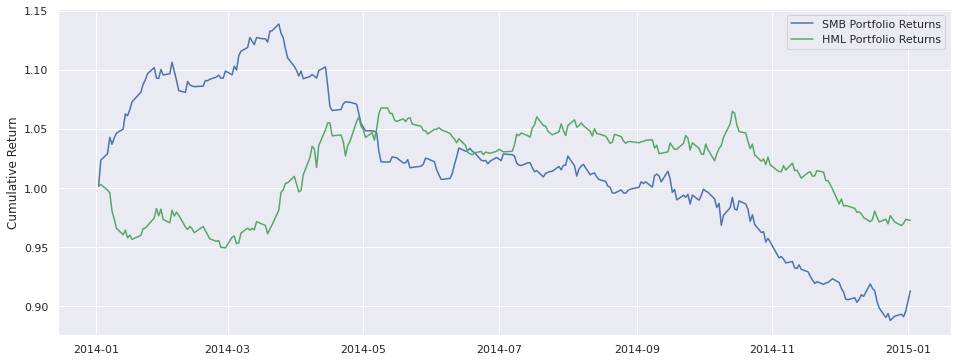

In [4]:
SMB_CUM = np.cumprod(SMB+1)
HML_CUM = np.cumprod(HML+1)

plt.plot(SMB_CUM.index, SMB_CUM.values)
plt.plot(HML_CUM.index, HML_CUM.values)
plt.ylabel('Cumulative Return')
plt.legend(['SMB Portfolio Returns', 'HML Portfolio Returns']);

## Computing Risk Exposure

Now we can determine how exposed another return stream is to each of these factors. We can do this by running static or rolling linear regressions between our return stream and the factor portfolio returns. First we'll compute the active returns (returns - benchmark) of some random asset and then model that asset as a linear combination of our two factors. The more a factor contributes to the active returns, the more exposed the active returns are to that factor.

In [5]:
from quantrocket.master import get_securities
from quantrocket import get_prices

securities = get_securities(symbols=['MSFT', 'AAPL', 'YHOO', 'FB', 'TSLA'], vendors='usstock')

# Get returns data for our portfolio
portfolio = get_prices(
    'usstock-1d-bundle',
    data_frequency='daily',
    sids=securities.index.tolist(),
    fields='Close', 
    start_date=start_date, 
    end_date=end_date).loc['Close'].pct_change()[1:]
R = np.mean(portfolio, axis=1)

SPY = get_securities(symbols='SPY', vendors='usstock').index[0]

bench = get_prices(
    'usstock-1d-bundle', 
    data_frequency='daily',
    sids=SPY,
    fields='Close', 
    start_date=start_date, 
    end_date=end_date).loc['Close'][SPY].pct_change()[1:]

# The excess returns of our active management, in this case just holding a portfolio of our one asset
active = R - bench

# Define a constant to compute intercept
constant = pd.Series(np.ones(len(active.index)), index=active.index)

df = pd.DataFrame({'R': active,
              'F1': SMB.tz_localize(None),
              'F2': HML.tz_localize(None),
              'Constant': constant})
df = df.dropna()

In [6]:
# Perform linear regression to get the coefficients in the model
b1, b2 = regression.linear_model.OLS(df['R'], df[['F1', 'F2']]).fit().params

# Print the coefficients from the linear regression
print('Sensitivities of active returns to factors:\nSMB: %f\nHML: %f' %  (b1, b2))

Sensitivities of active returns to factors:
SMB: -0.027129
HML: -0.047605


Using the formula from the start of the notebook, we can compute the factors' marginal contributions to active risk squared:

In [7]:
F1 = df['F1']
F2 = df['F2']
cov = np.cov(F1, F2)
ar_squared = (active.std())**2
fmcar1 = (b1*(b2*cov[0,1] + b1*cov[0,0]))/ar_squared
fmcar2 = (b2*(b1*cov[0,1] + b2*cov[1,1]))/ar_squared
print('SMB Risk Contribution:', fmcar1)
print('HML Risk Contribution:', fmcar2)

SMB Risk Contribution: 0.00022347420398894437
HML Risk Contribution: 0.000645267708587981


The rest of the risk can be attributed to active specific risk, i.e. factors that we did not take into account or the asset's idiosyncratic risk.

## Factor and tracking portfolios

We can use factor and tracking portfolios to tweak a portfolio's sensitivities to different sources of risk.

A <i>factor portfolio</i> has a sensitivity of 1 to a particular factor and 0 to all other factors. In other words, it represents the risk of that one factor. We can add a factor portfolio to a larger portfolio to adjust its exposure to that factor.

A similar concept is a <i>tracking portfolio</i>, which is constructed to have the same factor sensitivities as a benchmark or other portfolio. Like a factor portfolio, this allows us to either speculate on or hedge out the risks associated with that benchmark or portfolio. For instance, we regularly hedge out the market, because we care about how our portfolio performs relative to the market, and we don't want to be subject to the market's fluctuations.

To construct a factor or tracking portfolio, we need the factor sensitivities of what we want to track. We already know what these are in the former case, but we need to compute them in the latter using usual factor model methods. Then, we pick some $K+1$ assets (where $K$ is the number of factors we're considering) and solve for the weights of the assets in the portfolio.

## Portfolio Exposure

The portfolio exposure can be computed directly from the return stream, or as the weighted average of all the assets held.

## Example

Say we have two factors $F_1$ and $F_2$, and a benchmark with sensitivities of 1 and 1.1 to the factors, respectively. We identify 3 securities $x_1, x_2, x_3$ that we would like to use in composing a portfolio that tracks the benchmark, whose sensitivities  are $b_{11} = 0.7$, $b_{12} = 1.1$, $b_{21} = 0.1$, $b_{22} = 0.5$, $b_{31} = 1.5$, $b_{32} = 1.3$. We would like to compute weights $w_1$, $w_2$, $w_3$ so that our tracking portfolio is

$$ P = w_1 x_1 + w_2 x_2 + w_3 x_3 $$

We want our portfolio sensitivities to match the benchmark:

$$ w_1 b_{11} + w_2 b_{21} + w_3 b_{31} = 1 $$
$$ w_1 b_{12} + w_2 b_{22} + w_3 b_{32} = 1.1 $$

Also, the weights need to sum to 1:

$$ w_1 + w_2 + w_3 = 1 $$

Solving this system of 3 linear equations, we find that $w_1 = 1/3$, $w_2 = 1/6$, and $w_3 = 1/2$. Putting the securities together into a portfolio using these weights, we obtain a portfolio with the same risk profile as the benchmark.

## How to Use Risk Exposure Models

Once we know our risk exposures, we can do a few things. We can not enter into positions that have high exposures to certain factors, or we can hedge our positions to try to neutralize the exposure.

### Risk Management

Often times funds will have a layer of protection over their traders/algorithms. This layer of protection takes in the trades that the fund wants to make, then computes the exposure of the new portfolio, and checks to make sure they're within pre-defined ranges. If they are not, it does not place the trade and files a warning.

### Hedging

Another method of dealing with exposure is to take out hedges. You can determine, for example, your exposure to each sector of the market. You can then take out a hedge if a particular sector seems to affect your returns too much. For more information on hedging, please see our Beta Hedging lecture. Good algorithms will have built-in hedging logic that ensures they are never over-exposed.

---

**Next Lecture:** [Risk-Constrained Portfolio Optimization](Lecture35-Risk-Constrained-Portfolio-Optimization.ipynb)

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian") or QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, neither Quantopian nor QuantRocket has taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. Neither Quantopian nor QuantRocket makes any guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*